<a href="https://colab.research.google.com/github/azariadr/Klasifikasi_Beras/blob/main/Klasifikasi_Beras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyek Klasifikasi Gambar: Rice Image Dataset
- **Nama:** Azaria Dhea Rismaya
- **Email:** aza.dhea@gmail.com
- **ID Dicoding:** azariadhear

## Import Semua Packages/Library yang Digunakan

In [2]:
import os
import shutil
import random

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import confusion_matrix, classification_report

## Data Preparation

### Data Loading

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"azariadhearismaya","key":"ba2c135e737734d2c8d384b3dbc81de6"}'}

In [4]:
!kaggle datasets download -d muratkokludataset/rice-image-dataset
!unzip rice-image-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (55).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (550).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5500).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5501).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5502).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5503).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5504).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5505).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5506).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5507).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5508).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5509).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (551).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5510).jpg  
  inflating: Rice_Image_Dataset/Karacadag/K

In [5]:
def move_images_to_directory(source_dir, destination_dir):
    for i, filename in enumerate(os.listdir(source_dir)):
        source_file = os.path.join(source_dir, filename)
        name, ext = os.path.splitext(filename)
        new_filename = f"{os.path.basename(source_dir)}_{i}{ext}"
        destination_file = os.path.join(destination_dir, new_filename)
        shutil.copy(source_file, destination_file)

destination_dir = "dataset"
os.makedirs(destination_dir, exist_ok=True)
source_dirs = [
    "Rice_Image_Dataset/Arborio",
    "Rice_Image_Dataset/Basmati",
    "Rice_Image_Dataset/Ipsala",
    "Rice_Image_Dataset/Jasmine",
    "Rice_Image_Dataset/Karacadag"
]

for source_dir in source_dirs:
    move_images_to_directory(source_dir, destination_dir)

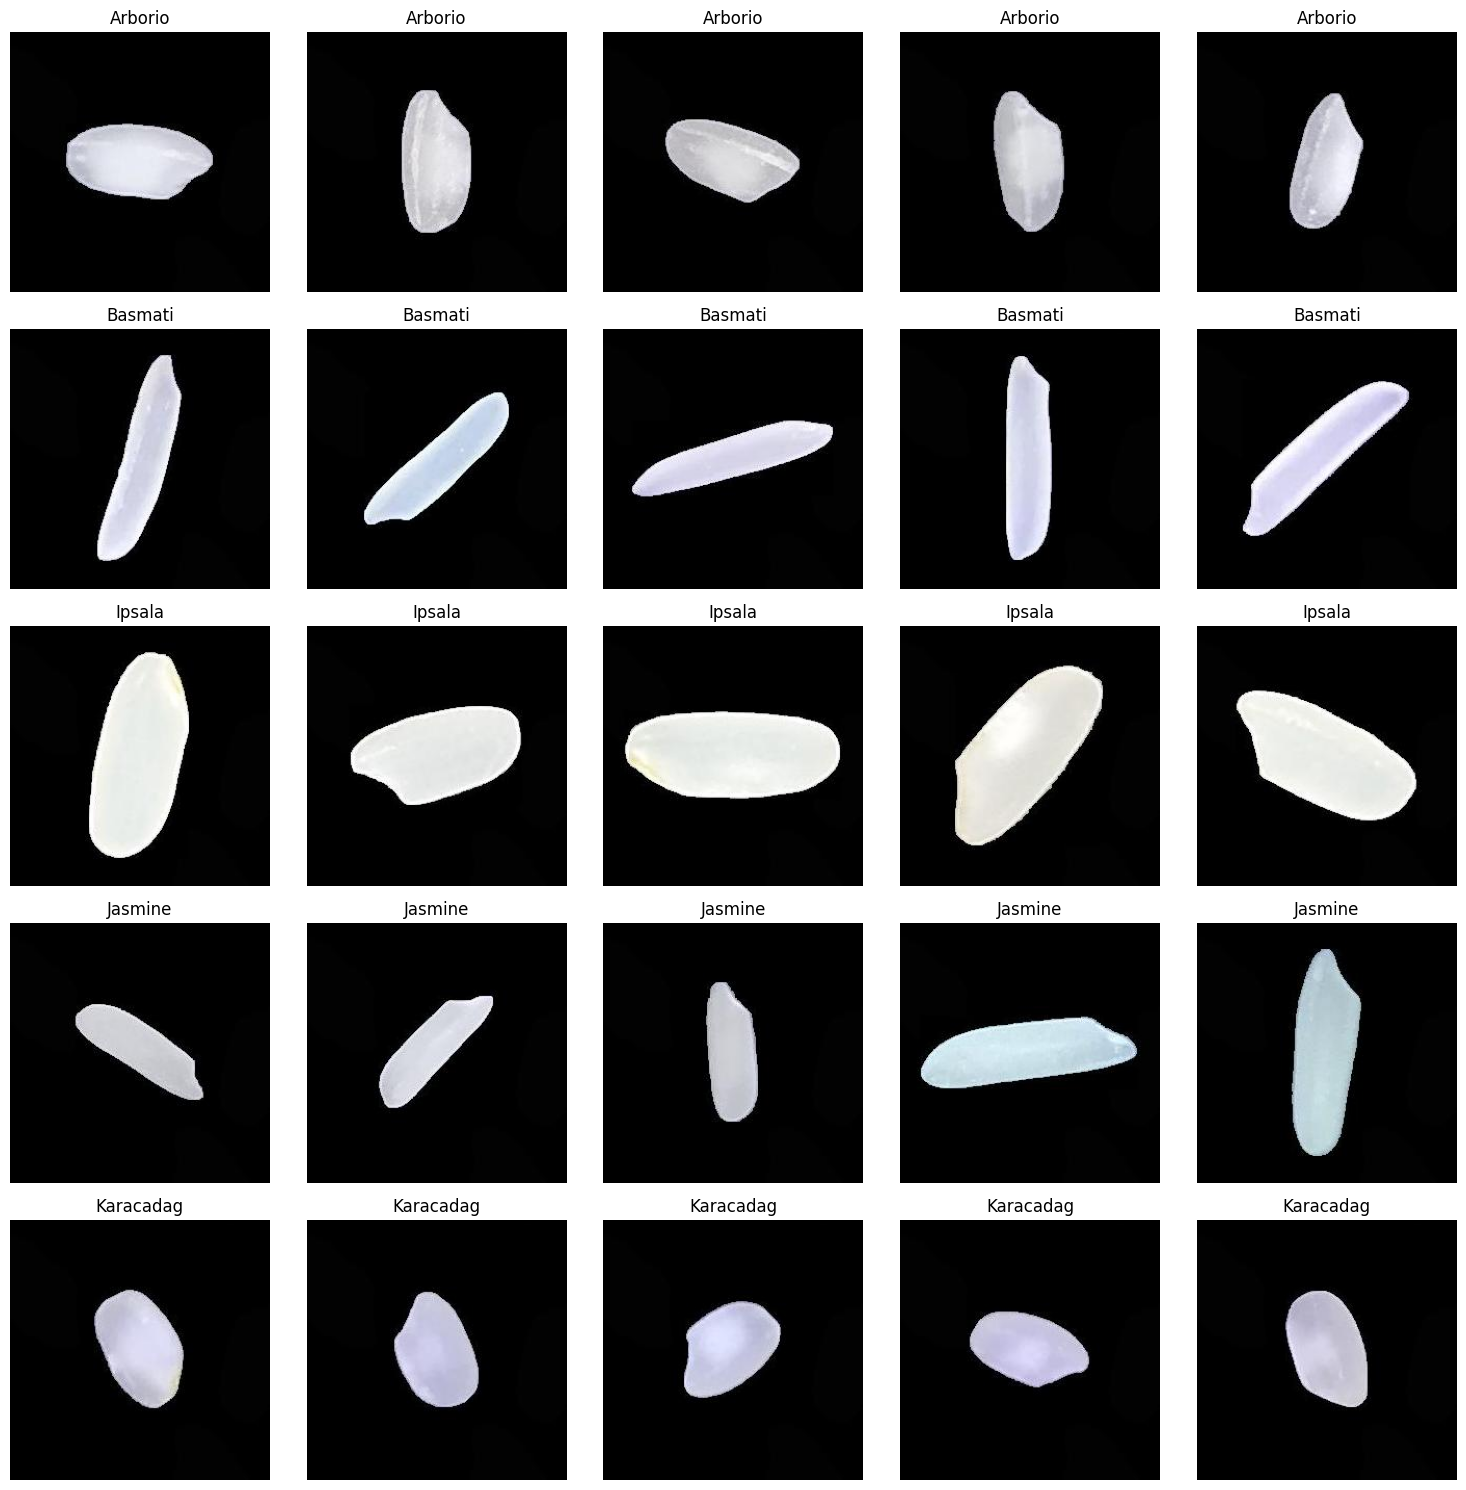

In [6]:
rice_types = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']
dataset_dir = 'dataset'

rice_images = {}
for rice_type in rice_types:
  rice_images[rice_type] = [os.path.join(dataset_dir, f) for f in os.listdir(dataset_dir) if rice_type in f]

fig, axes = plt.subplots(len(rice_types), 5, figsize=(15, 15))

for i, rice_type in enumerate(rice_types):
  random_images = random.sample(rice_images[rice_type], 5)
  for j, image_path in enumerate(random_images):
    img = mpimg.imread(image_path)
    axes[i, j].imshow(img)
    axes[i, j].set_title(rice_type)
    axes[i, j].axis('off')

plt.tight_layout()
plt.show()

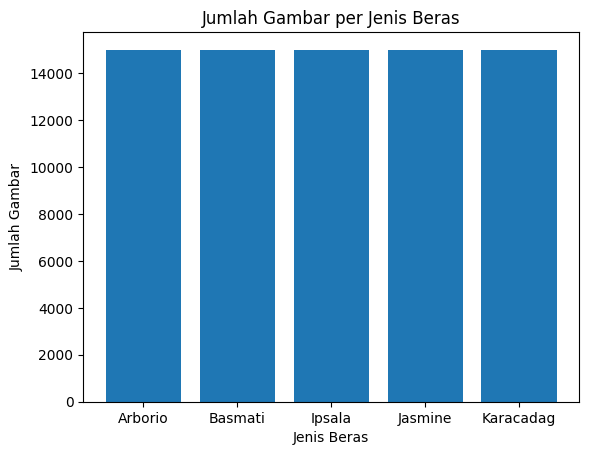

In [7]:
rice_types = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']
dataset_dir = 'dataset'

rice_counts = [len([f for f in os.listdir(dataset_dir) if rice_type in f]) for rice_type in rice_types]

plt.bar(rice_types, rice_counts)
plt.xlabel('Jenis Beras')
plt.ylabel('Jumlah Gambar')
plt.title('Jumlah Gambar per Jenis Beras')
plt.show()

### Data Preprocessing

#### Split Dataset

In [8]:
dataset_dir = "dataset"

rice_types = ["Arborio", "Basmati", "Ipsala", "Jasmine", "Karacadag"]

rice_counts = {rice_type: len([f for f in os.listdir(dataset_dir) if rice_type in f]) for rice_type in rice_types}
for rice_type, count in rice_counts.items():
    print(f"{rice_type}: {count}")

Arborio: 15000
Basmati: 15000
Ipsala: 15000
Jasmine: 15000
Karacadag: 15000


In [9]:
train_ratio = 0.8

train_dir = "training"
test_dir = "testing"
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

for rice_type in rice_types:
    os.makedirs(os.path.join(train_dir, rice_type), exist_ok=True)
    os.makedirs(os.path.join(test_dir, rice_type), exist_ok=True)

    images = [f for f in os.listdir(dataset_dir) if rice_type in f]

    random.shuffle(images)

    train_count = int(len(images) * train_ratio)

    train_images = images[:train_count]
    test_images = images[train_count:]

    for image in train_images:
        source_path = os.path.join(dataset_dir, image)
        destination_path = os.path.join(train_dir, rice_type, image)
        shutil.copy(source_path, destination_path)

    for image in test_images:
        source_path = os.path.join(dataset_dir, image)
        destination_path = os.path.join(test_dir, rice_type, image)
        shutil.copy(source_path, destination_path)

print('train size :', len(train_images))
print('test size :', len(test_images))

train size : 12000
test size : 3000


In [10]:
train_dir = "training"
test_dir = "testing"

train_counts = {}
test_counts = {}

for rice_type in rice_types:
    train_counts[rice_type] = len(os.listdir(os.path.join(train_dir, rice_type)))
    test_counts[rice_type] = len(os.listdir(os.path.join(test_dir, rice_type)))

print("Jumlah data training:")
for rice_type, count in train_counts.items():
    print(f"{rice_type}: {count}")

print("\nJumlah data testing:")
for rice_type, count in test_counts.items():
    print(f"{rice_type}: {count}")


Jumlah data training:
Arborio: 12000
Basmati: 12000
Ipsala: 12000
Jasmine: 12000
Karacadag: 12000

Jumlah data testing:
Arborio: 3000
Basmati: 3000
Ipsala: 3000
Jasmine: 3000
Karacadag: 3000


In [11]:
train_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)
train_data = train_gen.flow_from_directory(
    'training',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)
test_data=train_gen.flow_from_directory('testing',target_size=(224,224),batch_size=1,shuffle=False,subset='validation')

Found 48000 images belonging to 5 classes.
Found 3000 images belonging to 5 classes.


## Modelling

In [12]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(224, 224, 3)))
model.add(keras.layers.MaxPool2D(pool_size=2, strides=2))

model.add(keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(keras.layers.MaxPool2D(pool_size=2, strides=2))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(rate=0.6))
model.add(keras.layers.Dense(units=5, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.001), metrics=['accuracy'], loss='categorical_crossentropy')

model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 200704)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      25,690,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,710,277 (98.08 MB)

 Trainable params: 25,710,277 (98.08 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=20, verbose=1, restore_best_weights=True, mode='max')
model_checkpoint = ModelCheckpoint(filepath='best_model.keras', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=0.0001)

## Evaluasi dan Visualisasi

In [14]:
count_per_class = [len(os.listdir(os.path.join(train_dir, class_name))) for class_name in rice_types]

total_count = sum(count_per_class)

class_weights = {i: (1 / count) * (total_count) / len(rice_types) for i, count in enumerate(count_per_class)}

history = model.fit(train_data,
                        epochs=5,
                        batch_size=64,
                        validation_data=test_data,
                        class_weight=class_weights,
                        callbacks=[early_stopping, model_checkpoint, reduce_lr])

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5169 - loss: 1.1328
Epoch 1: val_accuracy improved from -inf to 0.87067, saving model to best_model.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6259s 4s/step - accuracy: 0.5170 - loss: 1.1327 - val_accuracy: 0.8707 - val_loss: 0.3690 - learning_rate: 0.0010
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7764 - loss: 0.5711
Epoch 2: val_accuracy improved from 0.87067 to 0.90800, saving model to best_model.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6150s 4s/step - accuracy: 0.7764 - loss: 0.5711 - val_accuracy: 0.9080 - val_loss: 0.2853 - learning_rate: 0.0010
Epoch 3/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8280 - loss: 0.4597
Epoch 3: val_accuracy improved from 0.90800 to 0.92033, saving model to best_model.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6249s 4s/step - accuracy: 0.8280 - loss: 0.4597 - val_accuracy: 0.9203 - val_loss: 0.2292 - learning_rate: 0.0010
Epoch 4/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step -

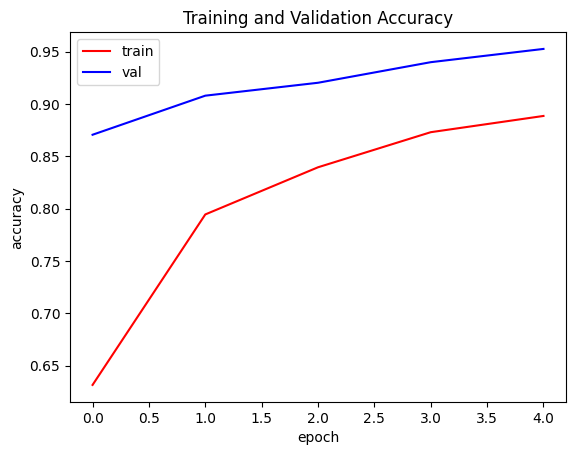

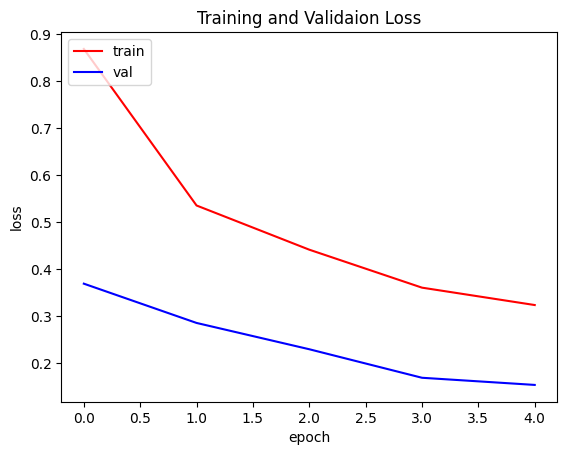

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

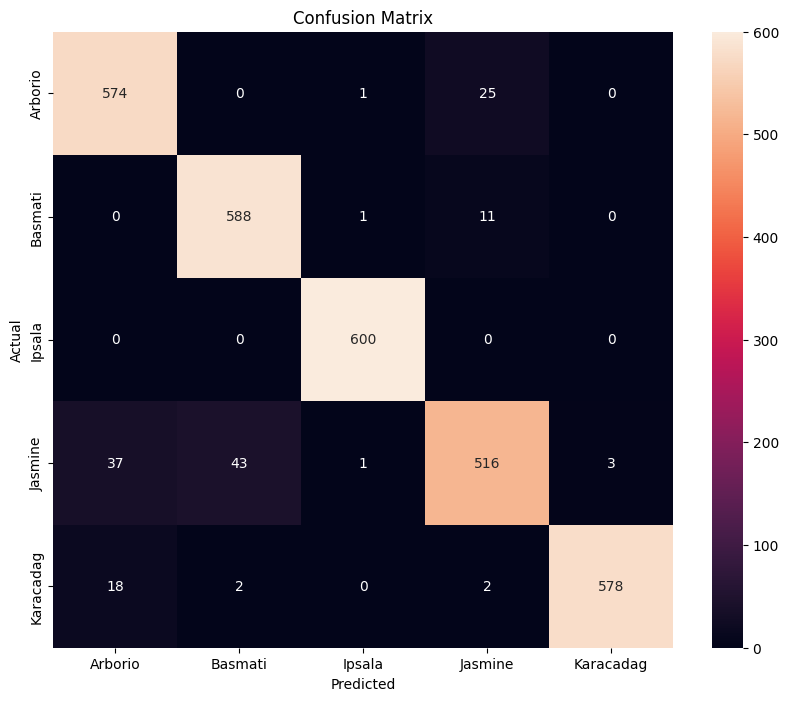


Classification Report:
              precision    recall  f1-score   support

     Arborio       0.91      0.96      0.93       600
     Basmati       0.93      0.98      0.95       600
      Ipsala       1.00      1.00      1.00       600
     Jasmine       0.93      0.86      0.89       600
   Karacadag       0.99      0.96      0.98       600

    accuracy                           0.95      3000
   macro avg       0.95      0.95      0.95      3000
weighted avg       0.95      0.95      0.95      3000



In [16]:
test_data.reset()

preds = model.predict(test_data,verbose=0)
predicted_classes = np.argmax(preds, axis=1)

cm = confusion_matrix(test_data.classes, predicted_classes)
cm = pd.DataFrame(cm, index=rice_types, columns=rice_types)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\nClassification Report:")
print(classification_report(test_data.classes, predicted_classes, target_names=rice_types))


## Konversi Model

In [17]:
save_path = 'saved_model/'
tf.saved_model.save(model, save_path)

In [20]:
model.save('rice_model.h5')
!pip install tensorflowjs
!tensorflowjs_converter --input_format keras rice_model.h5 saved_models/tfjs_model


  Using cached tensorflow-2.17.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.2 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 48.5 MB/s eta 0:00:00
Using cached tensorflow-2.17.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (601.3 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 36.0 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
      Successfully uninstalled packaging-24.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.16.2
    Uninstalling tensorboard-2.16.2:
      Successfully uninstalled tensorboard-2.16.2
  Attempting uninstall: tensorflow
    Found existing installatio

2024-09-06 14:30:55.215033: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-06 14:30:55.256638: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-06 14:30:55.268734: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-06 14:30:58.153273: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
failed to lookup keras version from the file,
    this is likely a weight only file


In [21]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('rice_model.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmp70kmqq_u'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  138970891890608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138970819304208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138970819114640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138970819106896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138970880707744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138970864223680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138970818897776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138970818894608: TensorSpec(shape=(), dtype=tf.resource, name=None)


## Inference

In [22]:
# TF-Lite
interpreter = tf.lite.Interpreter(model_path='rice_model.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

test_rice_dir = 'testing'
rice_types = ["Arborio", "Basmati", "Ipsala", "Jasmine", "Karacadag"]
random_rice_type = random.choice(rice_types)
random_folder = os.path.join(test_rice_dir, random_rice_type)
img_path = os.path.join(random_folder, random.choice(os.listdir(random_folder)))

img = load_img(img_path, target_size=(224, 224))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

interpreter.set_tensor(input_details[0]['index'], img_array)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

predicted_class = np.argmax(output_data)
predicted_label = rice_types[predicted_class]

print(f"Gambar: {img_path}")
print(f"Prediksi: {predicted_label}")

Gambar: testing/Basmati/Basmati_2304.jpg
Prediksi: Basmati


In [23]:
!pip freeze > requirements.txt

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [35]:
!git clone https://github.com/azariadr/Klasifikasi_Beras.git /content/drive/MyDrive/

fatal: destination path '/content/drive/MyDrive' already exists and is not an empty directory.
